In [1]:
import pandas as pd
import glob
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import pdb
import time
import calendar
import pyfftw
from tqdm.notebook import tqdm
from comb_utils import *

ω_start = 193.4160363481703 THz, ω_end = 193.41062074247742 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.0310006200125 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 5415605.69290625 GHz/s 
sweep speed (λ space) = 43400.52081312755 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 12894299.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 3.86828978065625 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 1.0199359714377958, Veff = 3.6128315516282617e-16, F^2 = 42.548069586909854


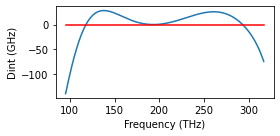

ω_start = 149.897428169832 THz, ω_end = 149.89323107542 THz
λ_start = 1999.9840001279988 nm, λ_end = 2000.040000800016 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 4197094.412 GHz/s 
sweep speed (λ space) = 56000.67201715737 nm/s
real time = 1e-06, normalized time = 149.896229 (relevant parameters: total_time), dt = 0.001
Simulation points = 9993081.0 (relevant parameters: dt)
detuning at start = -1.199169832 GHz, detuning at end = 2.99792458 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 8.
g0 = 0.31450397288908477, Veff = 7.037167544041137e-16, F^2 = 28.18564517566032


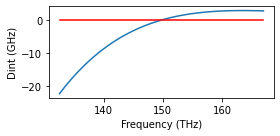

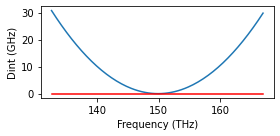

In [2]:
A = microring(R=25e-6,height=1e-6,width=2.3e-6,ng=2.2,Qc=1e6,Qi=1e6,n2=2.4e-19,
                δnorm_range=[-8,20],ω_range=[],λ_range=[],ω0=299792458/1.550e-6,λ0=None,
                total_time=1e-6,ω_sweep_speed=None,λ_sweep_speed=None,Qc_import=[],Dint_file='2.300w_58.5r_0.960h.csv',dt=1e-3,
                Nmodes=2**8,pump=200e-3,snapshots=2000,mode_offset=15,Dint_degrees=9)

D2 = 15e6 # Hz

numModes = 2**7
mu = np.arange(-numModes/2,numModes/2)
Dint = (mu**2*D2/2)

B = microring(R=80e-6,height=1e-6,width=1.4e-6,ng=2.2,Qc=1e6,Qi=1e6,n2=2.4e-19,
                δnorm_range=[-8,20],ω_range=[],λ_range=[],ω0=299792458/2e-6,λ0=None,
                total_time=1e-6,ω_sweep_speed=None,λ_sweep_speed=None,Qc_import=[],Dint_file=None,dt=1e-3,
                Nmodes=2**7,pump=200e-3,snapshots=2000,mode_offset=0,Dint_degrees=9)

B.Dint_arr = B.ifftshift(Dint,numModes//2)
B.plot_Dint()
# plt.plot(B.ifftshift(Dint,numModes//2))

In [18]:
A.c/A.fftshift(A.ωarr,A.idx)[0]

1.55e-06

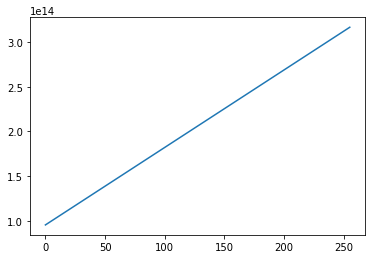

In [24]:
plt.plot(A.ωarr_adjusted)

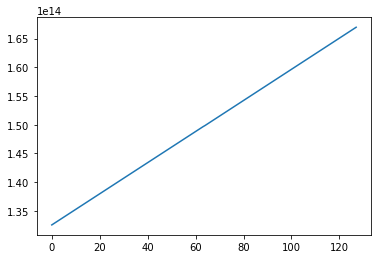

In [25]:
plt.plot(B.ωarr_adjusted)

In [73]:
def transfer_mask(A,B):
    # A modes to B modes
    '''For each B mode, find one A mode that is closest in frequency to the specified B mode'''
    ωA = A.ωarr_adjusted # A.fftshift(A.ωarr_adjusted,A.idx)
    ωB = B.ωarr_adjusted# B.fftshift(B.ωarr_adjusted,B.idx)
    Aidx = 0
    mask = []
    for ωb in ωB:
        currDiff = np.abs(ωA[Aidx]-ωb)
        while np.abs(ωA[Aidx]-ωb)<=currDiff:
            currDiff = np.abs(ωA[Aidx]-ωb)
            Aidx += 1 
            if Aidx == len(ωA):
                break
        Aidx -= 1
        mask.append(Aidx) # mask of A, which A mode as pump for B
    return np.array(mask)

A has 256 modes, B has 128 modes

In [78]:
mask_AtoB = transfer_mask(A,B)

In [79]:
mask_BtoA = transfer_mask(B,A)

In [129]:
%timeit mask_BtoA = transfer_mask(B,A)

1.58 ms ± 6.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [84]:
Amode_actlikepumps = A.ωarr_adjusted[mask_AtoB]

In [86]:
Bmode_actlikepumps = B.ωarr_adjusted[mask_BtoA]

In [89]:
len(Amode_actlikepumps)

128

In [90]:
len(Bmode_actlikepumps) # right length because there are 256 A modes that need pump from B

256

In [126]:
# check that for every B mode acting on A, there isn't another frequency that's closer
def check(mask_BtoA,A,B):
    diff = np.abs(B.ωarr_adjusted[mask_BtoA] - A.ωarr_adjusted)
    diff_lower = np.abs(B.ωarr_adjusted[mask_BtoA-1]- A.ωarr_adjusted)
    new_mask = [m+1 if m<len(B.ωarr_adjusted)-1 else m for m in mask_BtoA]
#     print(new_mask)
    diff_higher = np.abs(B.ωarr_adjusted[new_mask]- A.ωarr_adjusted)
    print((diff<diff_lower).all(),(diff<=diff_higher).all())
    try:
        print(np.where((diff<diff_higher)==False))
        print(new_mask[np.where((diff<diff_higher)==False)[0][0]])
    except:
        pass

In [127]:
check(mask_BtoA,A,B)

True True
(array([ 83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255]),)
127


In [128]:
check(mask_AtoB,B,A)

True True
(array([], dtype=int64),)


ω_start = 193.4160363481703 THz, ω_end = 193.41062074247742 THz
λ_start = 1549.9876000991992 nm, λ_end = 1550.0310006200125 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 5415605.69290625 GHz/s 
sweep speed (λ space) = 43400.52081312755 nm/s
real time = 1e-06, normalized time = 193.41448903225805 (relevant parameters: total_time), dt = 0.001
Simulation points = 12894299.0 (relevant parameters: dt)
detuning at start = -1.54731591225 GHz, detuning at end = 3.86828978065625 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 9.
g0 = 0.12749199642972447, Veff = 2.8902652413026093e-15, F^2 = 5.318508698363732


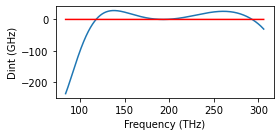

ω_start = 149.897428169832 THz, ω_end = 149.89323107542 THz
λ_start = 1999.9840001279988 nm, λ_end = 2000.040000800016 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 4197094.412 GHz/s 
sweep speed (λ space) = 56000.67201715737 nm/s
real time = 1e-06, normalized time = 149.896229 (relevant parameters: total_time), dt = 0.001
Simulation points = 9993081.0 (relevant parameters: dt)
detuning at start = -1.199169832 GHz, detuning at end = 2.99792458 GHz (relevant parametes: ω_range, λ_range)
Dint is a polynomial of order 8.
g0 = 0.04193386305187798, Veff = 5.2778756580308514e-15, F^2 = 3.758086023421378


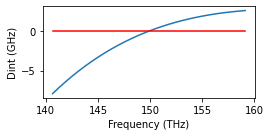

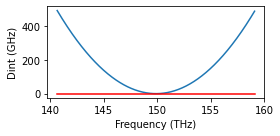

In [136]:
C = microring(R=200e-6,height=1e-6,width=2.3e-6,ng=2.2,Qc=1e6,Qi=1e6,n2=2.4e-19,
                δnorm_range=[-8,20],ω_range=[],λ_range=[],ω0=299792458/1.550e-6,λ0=None,
                total_time=1e-6,ω_sweep_speed=None,λ_sweep_speed=None,Qc_import=[],Dint_file='2.300w_58.5r_0.960h.csv',dt=1e-3,
                Nmodes=2**11,pump=200e-3,snapshots=2000,mode_offset=15,Dint_degrees=9)

D2 = 15e6 # Hz

numModes = 2**9
mu = np.arange(-numModes/2,numModes/2)
Dint = (mu**2*D2/2)

D = microring(R=600e-6,height=1e-6,width=1.4e-6,ng=2.2,Qc=1e6,Qi=1e6,n2=2.4e-19,
                δnorm_range=[-8,20],ω_range=[],λ_range=[],ω0=299792458/2e-6,λ0=None,
                total_time=1e-6,ω_sweep_speed=None,λ_sweep_speed=None,Qc_import=[],Dint_file=None,dt=1e-3,
                Nmodes=2**9,pump=200e-3,snapshots=2000,mode_offset=0,Dint_degrees=9)

D.Dint_arr = D.ifftshift(Dint,numModes//2)
D.plot_Dint()
# plt.plot(B.ifftshift(Dint,numModes//2))

In [142]:
mask_CtoD = transfer_mask(C,D)

In [143]:
mask_DtoC = transfer_mask(D,C)

In [144]:
check(mask_CtoD,D,C)

True True
(array([], dtype=int64),)


In [145]:
check(mask_DtoC,C,D)

True True
(array([ 693,  694,  695, ..., 2045, 2046, 2047]),)
511
